In [1]:
import cv2
import os
import numpy as np
import pandas as pd

In [2]:
video_file = '/kaggle/input/videodata/Q3/train.mp4'
output_dir = 'frames'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cap = cv2.VideoCapture(video_file)

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_filename = os.path.join(output_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_count += 1

cap.release()

print(f'{frame_count} frames extracted and saved to {output_dir}')

20400 frames extracted and saved to frames


In [3]:
file_path = '/kaggle/input/videodata/Q3/train.txt'

numbers = []

with open(file_path, 'r') as file:
    for line in file:
        numbers.append(float(line.strip()))


length = len(numbers)

print("Length:", length)

Length: 20400


In [4]:
df = pd.DataFrame({
    'frame': range(len(numbers)),
    'velocity': numbers
})

In [5]:
df.to_csv('frames_train.csv')

In [6]:
video_file = '/kaggle/input/videodata/Q3/test.mp4'
output_dir = 'frames_test'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cap = cv2.VideoCapture(video_file)

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_filename = os.path.join(output_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_count += 1

cap.release()

print(f'{frame_count} frames extracted and saved to {output_dir}')

10798 frames extracted and saved to frames_test


In [7]:
file_path = '/kaggle/input/videodata/Q3/test.txt'

numbers = []

with open(file_path, 'r') as file:
    for line in file:
        numbers.append(float(line.strip()))


length = len(numbers)

print("Length:", length)


Length: 10798


In [8]:
df = pd.DataFrame({
    'frame': range(len(numbers)),
    'velocity': numbers
})

In [9]:
df.to_csv('frames_test.csv')

In [10]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def convertToOptical(prev_image, curr_image):
    prev_image_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    curr_image_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_image_gray, curr_image_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    hsv = np.zeros_like(prev_image)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 255
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_image_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow_image_bgr

csv_file = 'frames_train.csv'
df = pd.read_csv(csv_file)

frames_dir = 'frames'

optical_flow_dir = 'optical_flow_frames'
os.makedirs(optical_flow_dir, exist_ok=True)

updated_velocities = []

for i in tqdm(range(len(df) - 1), desc="Processing frames"):
    frame1_path = os.path.join(frames_dir, f'frame_{df.loc[i, "frame"]:04d}.jpg')
    frame2_path = os.path.join(frames_dir, f'frame_{df.loc[i + 1, "frame"]:04d}.jpg')
    
    frame1 = cv2.imread(frame1_path)
    frame2 = cv2.imread(frame2_path)
    
    if frame1 is None or frame2 is None:
        print(f"Error loading frames: {frame1_path}, {frame2_path}")
        continue
    
    optical_flow_image = convertToOptical(frame1, frame2)
    
    optical_flow_path = os.path.join(optical_flow_dir, f'optical_flow_{df.loc[i, "frame"]:04d}.jpg')
    cv2.imwrite(optical_flow_path, optical_flow_image)
    
    new_velocity = df
    updated_velocities.append(new_velocity)

df.loc[1:, 'velocity'] = df['velocity'][i + 1]
df.to_csv('updated_frames_train.csv', index=False)

print("Optical flow calculation, image saving, and CSV update completed.")

Processing frames: 100%|██████████| 20399/20399 [34:33<00:00,  9.84it/s]

Optical flow calculation, image saving, and CSV update completed.


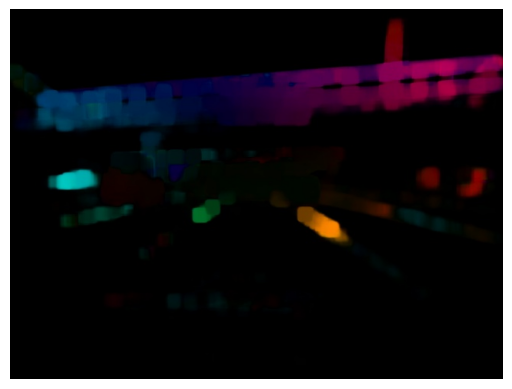

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/kaggle/working/optical_flow_frames/optical_flow_0000.jpg'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()


In [12]:
pd.read_csv('/kaggle/working/frames_train.csv')

,Unnamed: 0,frame,velocity
0,0,0,28.105569
1,1,1,28.105569
2,2,2,28.106527
3,3,3,28.130404
4,4,4,28.109243
...,...,...,...
20395,20395,20395,2.329180
20396,20396,20396,2.289795
20397,20397,20397,2.292917
20398,20398,20398,2.260600


In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import pandas as pd
import os

class VideoDataset(Dataset):
    def __init__(self, frames_folder, optical_flow_folder, csv_file, transform=None):
        self.frames_folder = frames_folder
        self.optical_flow_folder = optical_flow_folder
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.ls = len(self.df) - 1
        
    def __len__(self):
        return self.ls

    def __getitem__(self, idx):
        frame_num = self.df.iloc[idx]['frame']
        frame_i_path = os.path.join(self.frames_folder, f'frame_{idx:04d}.jpg')
        frame_ip1_path = os.path.join(self.frames_folder, f'frame_{idx+1:04d}.jpg')
        frame_opt_path = os.path.join(self.optical_flow_folder, f'optical_flow_{idx:04d}.jpg')
        
        if not (os.path.exists(frame_i_path) and os.path.exists(frame_ip1_path) and os.path.exists(frame_opt_path)):
            self.ls = idx - 1
            return self.__getitem__(0)

        try:
            img_i = Image.open(frame_i_path).convert('RGB')
            img_ip1 = Image.open(frame_ip1_path).convert('RGB')
            img_opt = Image.open(frame_opt_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            return self.__getitem__((idx + 1) % self.__len__())

        if self.transform:
            img_i = self.transform(img_i)
            img_ip1 = self.transform(img_ip1)
            img_opt = self.transform(img_opt)

        velocity = self.df.iloc[idx]['velocity']

        return img_i, img_ip1, img_opt, velocity


In [15]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

def convertToOptical(prev_image, curr_image):
    prev_image_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    curr_image_gray = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev_image_gray, curr_image_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    hsv = np.zeros_like(prev_image)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,1] = 255
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_image_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow_image_bgr

csv_file = '/kaggle/working/frames_test.csv'
df = pd.read_csv(csv_file)

frames_dir = 'frames_test'

optical_flow_dir = 'optical_flow_frames_test'
os.makedirs(optical_flow_dir, exist_ok=True)


for i in tqdm(range(len(df) - 1), desc="Processing frames"):
    frame1_path = os.path.join(frames_dir, f'frame_{df.loc[i, "frame"]:04d}.jpg')
    frame2_path = os.path.join(frames_dir, f'frame_{df.loc[i + 1, "frame"]:04d}.jpg')
    
    frame1 = cv2.imread(frame1_path)
    frame2 = cv2.imread(frame2_path)
    
    if frame1 is None or frame2 is None:
        print(f"Error loading frames: {frame1_path}, {frame2_path}")
        continue
    
    optical_flow_image = convertToOptical(frame1, frame2)
    
    optical_flow_path = os.path.join(optical_flow_dir, f'optical_flow_{df.loc[i, "frame"]:04d}.jpg')
    cv2.imwrite(optical_flow_path, optical_flow_image)
    


print("Optical flow calculation, image saving, and CSV update completed.")

Processing frames: 100%|██████████| 10797/10797 [18:17<00:00,  9.84it/s]

Optical flow calculation, image saving, and CSV update completed.


In [45]:
frames_folder = '/kaggle/working/frames'
optical_flow_folder = '/kaggle/working/optical_flow_frames_test'
csv_file = '/kaggle/working/frames_test.csv'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = VideoDataset(frames_folder, optical_flow_folder, csv_file, transform=transform)

In [46]:
frames_folder = '/kaggle/working/frames_test'
optical_flow_folder = '/kaggle/working/optical_flow_frames'
csv_file = '/kaggle/working/frames_train.csv'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = VideoDataset(frames_folder, optical_flow_folder, csv_file, transform=transform)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN_Regressor(nn.Module):
    def __init__(self):
        super(CNN_Regressor, self).__init__()
        
        resnet = models.resnet50(pretrained=True)
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        self.regressor = nn.Sequential(
            nn.Linear(2048, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, img_i, img_ip1, img_opt):
        img_optf = self.backbone(img_opt)
        
        img_optf_flat = torch.flatten(img_optf, start_dim=1)
        
        return self.regressor(img_optf_flat)


In [41]:
temp = CNN_Regressor()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
img_i, img_ip1, img_opt, velocity = dataset[0]

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

batch_size = 32
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN_Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
    
    for img_i, img_ip1, img_opt, velocity in pbar:
        img_i, img_ip1, img_opt, velocity = img_i.to(device), img_ip1.to(device), img_opt.to(device), velocity.to(device)
        
        optimizer.zero_grad()
        
        output = model(img_i, img_ip1, img_opt)
        
        loss = criterion(output, velocity.unsqueeze(1).float())
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * img_i.size(0)
        
        pbar.set_postfix({'loss': running_loss / ((pbar.n + 1) * batch_size)})
    
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_loss:.4f}')

    model.eval()
    test_loss = 0.0
    
    pbar = tqdm(test_loader, desc=f'Test Epoch {epoch + 1}/{num_epochs}')
    
    with torch.no_grad():
        for img_i, img_ip1, img_opt, velocity in pbar:
            img_i, img_ip1, img_opt, velocity = img_i.to(device), img_ip1.to(device), img_opt.to(device), velocity.to(device)
            
            output = model(img_i, img_ip1, img_opt)
            
            loss = criterion(output, velocity.unsqueeze(1).float())
            
            test_loss += loss.item() * img_i.size(0)
            
            pbar.set_postfix({'test_loss': test_loss / ((pbar.n + 1) * batch_size)})
    
    test_loss /= len(test_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 338/338 [03:32<00:00,  1.59it/s, loss=9.22]


Epoch 1/10 - Training Loss: 9.2432


Test Epoch 1/10: 100%|██████████| 638/638 [05:28<00:00,  1.94it/s, test_loss=176] 


Epoch 1/10 - Test Loss: 176.2627


Epoch 2/10: 100%|██████████| 338/338 [03:28<00:00,  1.62it/s, loss=6.25]


Epoch 2/10 - Training Loss: 6.2641


Test Epoch 2/10: 100%|██████████| 638/638 [05:27<00:00,  1.95it/s, test_loss=115] 


Epoch 2/10 - Test Loss: 114.6445


Epoch 3/10: 100%|██████████| 338/338 [03:27<00:00,  1.63it/s, loss=5.17]


Epoch 3/10 - Training Loss: 5.1789


Test Epoch 3/10: 100%|██████████| 638/638 [05:19<00:00,  2.00it/s, test_loss=99.6]


Epoch 3/10 - Test Loss: 99.7103


Epoch 4/10: 100%|██████████| 338/338 [03:28<00:00,  1.62it/s, loss=4]   


Epoch 4/10 - Training Loss: 4.0042


Test Epoch 4/10: 100%|██████████| 638/638 [05:26<00:00,  1.95it/s, test_loss=164] 


Epoch 4/10 - Test Loss: 163.8997


Epoch 5/10: 100%|██████████| 338/338 [03:28<00:00,  1.62it/s, loss=3.11]


Epoch 5/10 - Training Loss: 3.1168


Test Epoch 5/10: 100%|██████████| 638/638 [05:26<00:00,  1.95it/s, test_loss=168] 


Epoch 5/10 - Test Loss: 168.0460


Epoch 6/10: 100%|██████████| 338/338 [03:27<00:00,  1.63it/s, loss=2.78]


Epoch 6/10 - Training Loss: 2.7883


Test Epoch 6/10: 100%|██████████| 638/638 [05:19<00:00,  2.00it/s, test_loss=147] 


Epoch 6/10 - Test Loss: 146.7817


Epoch 7/10: 100%|██████████| 338/338 [03:29<00:00,  1.61it/s, loss=2.02]


Epoch 7/10 - Training Loss: 2.0219


Test Epoch 7/10: 100%|██████████| 638/638 [05:29<00:00,  1.94it/s, test_loss=171] 


Epoch 7/10 - Test Loss: 171.7210


Epoch 8/10: 100%|██████████| 338/338 [03:27<00:00,  1.63it/s, loss=1.64]


Epoch 8/10 - Training Loss: 1.6404


Test Epoch 8/10: 100%|██████████| 638/638 [05:27<00:00,  1.95it/s, test_loss=167] 


Epoch 8/10 - Test Loss: 166.9188


Epoch 9/10: 100%|██████████| 338/338 [03:28<00:00,  1.62it/s, loss=1.36]


Epoch 9/10 - Training Loss: 1.3628


Test Epoch 9/10: 100%|██████████| 637/637 [05:20<00:00,  1.99it/s, test_loss=123] 


Epoch 9/10 - Test Loss: 122.9667


Epoch 10/10: 100%|██████████| 338/338 [03:26<00:00,  1.64it/s, loss=1.48]


Epoch 10/10 - Training Loss: 1.4880


Test Epoch 10/10: 100%|██████████| 637/637 [05:17<00:00,  2.01it/s, test_loss=192] 

Epoch 10/10 - Test Loss: 191.6698


In [26]:
import os

directory_path = '/kaggle/working/frames_test'

try:
    file_count = len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])
    print(f"Number of files in '{directory_path}': {file_count}")
except FileNotFoundError:
    print("Directory not found")


Number of files in '/kaggle/working/frames_test': 10798


In [33]:
csv_file = '/kaggle/working/frames_test.csv'
df_ = pd.read_csv(csv_file)

In [34]:
df_dropped = df_.iloc[:-2]

In [35]:
df_dropped.to_csv(csv_file)